In [1]:
from datasets import load_dataset
from utils import jpeg_compress, webp_compress, pad, crop, nn_compress, hific_lo_compress
import compressai
from transformers import SegformerForSemanticSegmentation
import PIL
from torchvision import transforms
import torch
from torchmetrics.classification import MulticlassJaccardIndex
import numpy as np

2023-12-05 14:44:03.521601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 14:44:03.521649: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 14:44:03.521692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def jpeg_compress_ade(sample):
    img,bpp = jpeg_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample
    
def webp_compress_ade(sample):
    img,bpp = webp_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

net_mbt2018 = compressai.zoo.mbt2018(quality=1, pretrained=True).eval().to("cpu")
def mbt2018_compress_ade(sample):
    img,bpp = nn_compress(sample['image'],net_mbt2018,"cpu")
    sample['image'] = img
    sample['bpp'] = bpp
    return sample

def hific_lo_compress_ade(sample):
    img,bpp = hific_lo_compress(sample['image'])
    sample['image'] = img
    sample['bpp' ] = bpp
    return sample

In [3]:
image_compression_methods = [
    jpeg_compress_ade,
    webp_compress_ade,
    # mbt2018_compress_ade,
    # hific_lo_compress_ade
]
models = [
    "nvidia/segformer-b0-finetuned-ade-512-512",
    # "nvidia/segformer-b2-finetuned-ade-512-512",
    # "nvidia/segformer-b5-finetuned-ade-640-640"
]

In [4]:
ade20k = [load_dataset("scene_parse_150",split='validation')]

In [274]:
model = SegformerForSemanticSegmentation.from_pretrained(models[0]).cuda()

config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

In [275]:
iou = []
for sample in ade20k[0]:
    ground_truth = sample['annotation']
    img = sample['image'].resize((512,512))
    with torch.no_grad():
        inputs = transforms.ToTensor()(img).unsqueeze(0).to(torch.float).to("cuda")
        outputs = model(inputs).logits[0]
        predicted = transforms.ToPILImage()(outputs.argmax(dim=0).to(torch.uint8))
        predicted = predicted.resize((ground_truth.width,ground_truth.height),PIL.Image.Resampling.NEAREST)
        x1 = transforms.PILToTensor()(ground_truth) 
        x2 = transforms.PILToTensor()(predicted)
        x1 = x1-1
        iou.append(
            MulticlassJaccardIndex(num_classes=151,average='micro',ignore_index=255)
            (x1,x2).item()
        )
    # inputs = extractor(images=img, return_tensors="pt",do_resize=False).to("cuda:0")
    # outputs = model(**inputs)
    # logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    # predictions = logits.argmax(dim=1)[0].detach().cpu()
    # resize = transforms.Resize(
    #     (ground_truth.height,ground_truth.width),
    #     antialias=True
    # )
    # predictions = resize(
    #     predictions.unsqueeze(0).unsqueeze(0)
    # )[0][0]

    # x.append(np.array(ground_truth))
    # y.append(np.array(predictions))
# iou = torch.vstack(iou)

In [276]:
np.mean(iou)

0.615363365973346

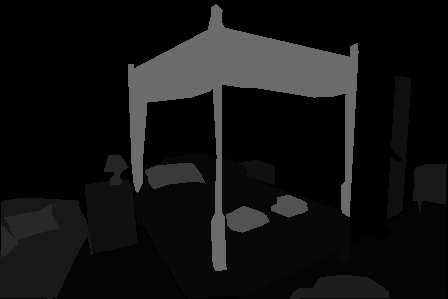

In [277]:
ground_truth

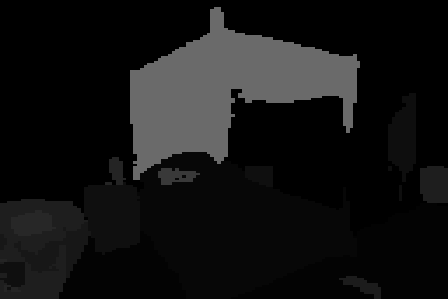

In [278]:
predicted

In [6]:
mean_iou = evaluate.load("mean_iou")

In [5]:
for method in image_compression_methods:
    ade20k.append(ade20k[0].map(method))

In [6]:
def evaluate_segmentation_miou(data):
    iou = []
    for sample in data:
        ground_truth = sample['annotation']
        img = sample['image'].resize((512,512))
        with torch.no_grad():
            inputs = transforms.ToTensor()(img).unsqueeze(0).to(torch.float).to("cuda")
            outputs = model(inputs).logits[0]
            predicted = transforms.ToPILImage()(outputs.argmax(dim=0).to(torch.uint8))
            predicted = predicted.resize((ground_truth.width,ground_truth.height),PIL.Image.Resampling.NEAREST)
            x1 = transforms.PILToTensor()(ground_truth) 
            x2 = transforms.PILToTensor()(predicted)
            x1 = x1-1
            iou.append(
                MulticlassJaccardIndex(num_classes=151,average='micro',ignore_index=255)
                (x1,x2).item()
            )
    return np.mean(iou)

In [ ]:
    # x = []
    # y = []
    # for sample in data:
    #     ground_truth = sample['annotation']
    #     img = sample['image']
    #     inputs = extractor(images=img, return_tensors="pt",do_resize=False).to("cuda:0")
    #     outputs = model(**inputs)
    #     logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    #     predictions = logits.argmax(dim=1)[0].detach().cpu()
    #     resize = transforms.Resize(
    #         (ground_truth.height,ground_truth.width),
    #         antialias=True
    #     )
    #     predictions = resize(
    #         predictions.unsqueeze(0).unsqueeze(0)
    #     )[0][0]
    
    #     x.append(np.array(ground_truth))
    #     y.append(np.array(predictions))
    # return mean_iou.compute(
    #     predictions=y,
    #     references=x,
    #     num_labels=150,
    #     ignore_index=255,
    #     reduce_labels=True
    # )['mean_iou']

In [ ]:
eval_results = []
for i_model,model_name in enumerate(models):
    eval_results.append([])
    model = SegformerForSemanticSegmentation.from_pretrained(model_name).to("cuda:0")
    for i_method,method in enumerate(ade20k):
        print(i_model, ",", i_method)
        eval_results[i_model].append(
            evaluate_segmentation_miou(method)
        )

0 , 0
0 , 1
0 , 2


In [ ]:
eval_results

In [12]:
segmentation_miou = eval_results[0]

In [13]:
baseline_miou = segmentation_miou[0]
segmentation_miou = segmentation_miou[1:]

In [14]:
image_bpp = [np.mean(method['bpp']) for method in ade20k[1:]]
image_bpp

[0.2616756840709221,
 0.13477392121864096,
 0.13477048131961145,
 0.025415553682810475]

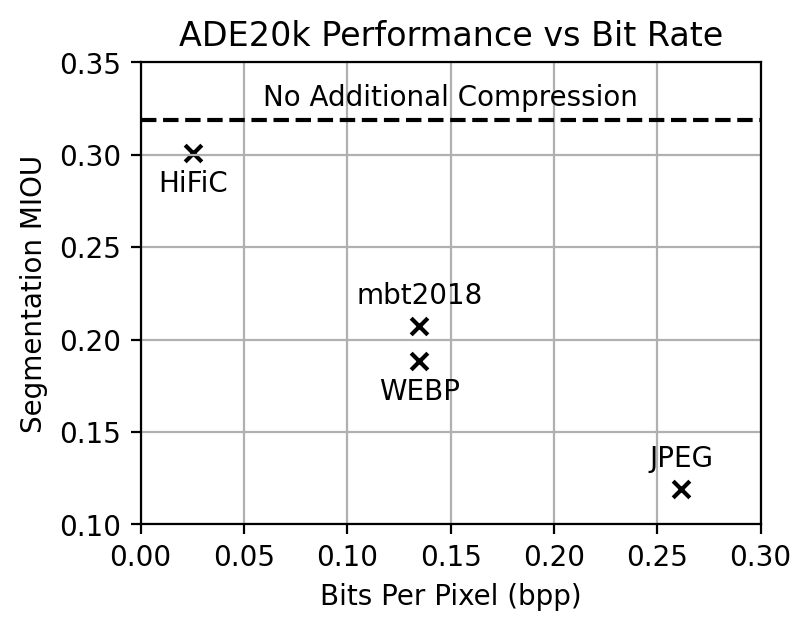

In [42]:
import matplotlib.pyplot as plt
image_compression_names = [
    'JPEG',
    'WEBP',
    'mbt2018',
    'HiFiC'
]
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(image_bpp, segmentation_miou, c='black', marker='x')
plt.annotate("No Additional Compression", (0.15, baseline_miou), textcoords="offset points", xytext=(0,5), ha='center')
plt.plot([0,1],[baseline_miou,baseline_miou],'--',c='black')
for i, name in enumerate(image_compression_names):
    if i == 1:
        offset = (0,-14)
    elif i == 3:
        offset = (0,-14)
    else:
        offset = (0,8)
    plt.annotate(name, (image_bpp[i], segmentation_miou[i]), textcoords="offset points", xytext=offset, ha='center')
plt.xlabel('Bits Per Pixel (bpp)')
plt.ylabel('Segmentation MIOU')
plt.title('ADE20k Performance vs Bit Rate')
plt.xlim([0,0.3])
plt.ylim([0.1,0.35])
plt.grid(True)
plt.show()